# Grid Search for Binary Classification

This notebook goes through applying the `grid_search` algorithm in FairLearn to a binary classification problem, where we also have a binary protected attribute.

The specific problem we consider a biased credit scoring problem. We assume that we have a collection of individuals characterised by two features - a credit score in the range $[0, 1]$ and a binary protected attribute from ${a_0, a_1}$. We also have a binary 'score' for each individual indicating whether or not they got a loan. This is determined by applying a threshold to their credit score, and to make the dataset unfair, we can set different thresholds for the two groups $a_0$ and $a_1$.

In this simple case, we make the protected attribute and the credit score available to both the learner and the model. This gives us a straightforward method of assessing fairness - look at the model, and see if zero weight is put on the protected attribute.

In [1]:
import sys
sys.path.insert(0, "../")

import fairlearn.grid_search.binary_protected_attribute.binary_classification as bc

import numpy as np
import pandas as pd

from test import simple_learners

We use the following function to create the input data. The credit scores for each population are uniformly distributed in the range $[0, 1]$, and we apply separate thresholds to each subpopulation to determine the score $Y \in {0, 1}$. We also add an extra constant feature to the data. This is needed to allow the toy learner we use to create a good fit.

In [2]:
def simple_threshold_data(number_a0, number_a1,
                          a0_threshold, a1_threshold,
                          a0_label, a1_label):

    a0s = np.full(number_a0, a0_label)
    a1s = np.full(number_a1, a1_label)

    a0_scores = np.linspace(0, 1, number_a0)
    a1_scores = np.linspace(0, 1, number_a1)
    score_feature = np.concatenate((a0_scores, a1_scores), axis=None)

    A = np.concatenate((a0s, a1s), axis=None)

    Y_a0 = [x > a0_threshold for x in a0_scores]
    Y_a1 = [x > a1_threshold for x in a1_scores]

    Y = np.concatenate((Y_a0, Y_a1), axis=None)

    X = pd.DataFrame({"credit_score_feature": score_feature,
                      "protected_attribute_feature": A,
                      "constant_ones_feature": np.ones(len(Y))})
    return X, Y, A

We now use the above function to generate our dataset. We have 31 individuals with label $a_0$, and they only require a credit score of 0.2 to get the loan. In contrast, the 21 members of the $a_1$ population require a score of 0.7. The actual label values for $a_0$ and $a_1$ have to be numeric, but the actual values are not important. We set them to carefully chosen random numbers.

In [3]:
num_samples_a0 = 31
num_samples_a1 = 21

a0_threshold= 0.2
a1_threshold = 0.7

a0_label = 45
a1_label = 18

X, Y, A = simple_threshold_data(num_samples_a0, num_samples_a1, a0_threshold, a1_threshold, a0_label, a1_label)

The following helper function plots the score $Y$ for each of the subpopulations in our data.

In [4]:
import matplotlib.pyplot as plt
def plot_data(Xs, Ys):
    labels = np.unique(Xs["protected_attribute_feature"])
    
    for l in labels:
        label_string = str(l.item())
        mask = Xs["protected_attribute_feature"] == l
        plt.scatter(Xs[mask].credit_score_feature, Ys[mask], label=str("Label="+label_string))
        plt.xlabel("Credit Score")
        plt.ylabel("Got Loan")
        
    plt.legend()
    plt.show()

Plotting the input data, we can clearly see the bias against the $a_1$ population.

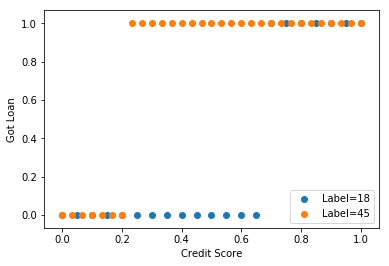

In [5]:
plot_data(X, Y)

For this notebook, we use a very simple binary classifier. This performs linear regression on the input features (hence the requirement for the $a_0$ and $a_1$ labels to be numeric), and then checks whether or not the result is greater than 0.5. We can train this model on our biased data, and look at the weights the regression places on each feature. The fact that the `protected_attribute_feature` has non-zero weight tells us that we have a biased model (note that this is only true for this simple example - in the real world, fairness is more complicated).

In [6]:
unfair_model = simple_learners.LeastSquaresBinaryClassifierLearner()
unfair_model.fit(X, Y, sample_weight=np.ones(len(Y)))

unfair_model.weights

constant_ones_feature         -0.521404
credit_score_feature           1.121662
protected_attribute_feature    0.016328
dtype: float64

We can also plot out the predictions for this model. We can see that a few points have changed (which is not unexpected) but the bias definitely remains.

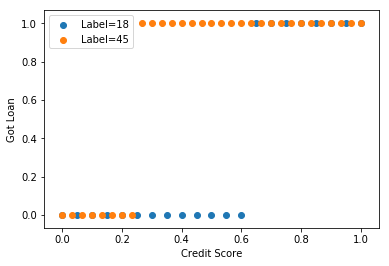

In [7]:
Y_predict_unfair = unfair_model.predict(X)
plot_data(X, Y_predict_unfair)

## Reducing Unfairness

Now, we move on to attempting to reduce the unfairness in our model using the grid search. This tries a series of different models, parameterised by a Lagrange multip

In [ ]:
first_sweep = bc.sweep_demographic_parity(simple_learners.LeastSquaresBinaryClassifierLearner(),
            X, Y, A, number_lagrange_multipliers=7)

In [ ]:
lagrange_multipliers = [x["lagrange_multiplier"] for x in first_sweep]
lagrange_multipliers

In [ ]:
first_sweep_protected_attribute_weights = [
            x["model"].weights["protected_attribute_feature"] for x in first_sweep]


In [ ]:
plt.scatter(lagrange_multipliers, first_sweep_protected_attribute_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [ ]:
import bisect

best_first_index = bisect.bisect(first_sweep_protected_attribute_weights, 0)
print(first_sweep_protected_attribute_weights[(best_first_index-1):best_first_index+1])

best_model_first_sweep = first_sweep[best_first_index]["model"]
best_model_first_sweep.weights

In [ ]:
Y_first_predict = best_model_first_sweep.predict(X)

In [ ]:
plot_data(X, Y_first_predict)

In [ ]:
second_sweep_multipliers = np.linspace(first_sweep[best_first_index-1]["lagrange_multiplier"],
                                      first_sweep[best_first_index]["lagrange_multiplier"],
                                      31)
second_sweep = bc.sweep_demographic_parity(simple_learners.LeastSquaresBinaryClassifierLearner(),
            X, Y, A, lagrange_multipliers=second_sweep_multipliers, number_lagrange_multipliers=None)

In [ ]:
second_sweep_protected_attribute_weights = [
            x["model"].weights["protected_attribute_feature"] for x in second_sweep]
second_sweep_lagrange_multipliers = [x["lagrange_multiplier"] for x in second_sweep]
plt.scatter(second_sweep_lagrange_multipliers, second_sweep_protected_attribute_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [ ]:
best_second_index = bisect.bisect(second_sweep_protected_attribute_weights, 0)
print(best_second_index)
print(second_sweep_protected_attribute_weights[(best_second_index-1):best_second_index+1])

In [ ]:
best_model_second_sweep = second_sweep[best_second_index]["model"]
best_model_second_sweep.weights

In [ ]:
Y_second_predict = best_model_second_sweep.predict(X)
plot_data(X, Y_second_predict)